In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/.julia/dev/ProactiveHRI`


In [2]:
include("dynamics.jl")
include("planner_utils.jl")
include("utils.jl")
include("planner.jl")
include("plotting.jl")

plot_solve_solution (generic function with 1 method)

  2.701048 seconds (6.91 M allocations: 469.014 MiB, 6.09% gc time, 99.43% compilation time)


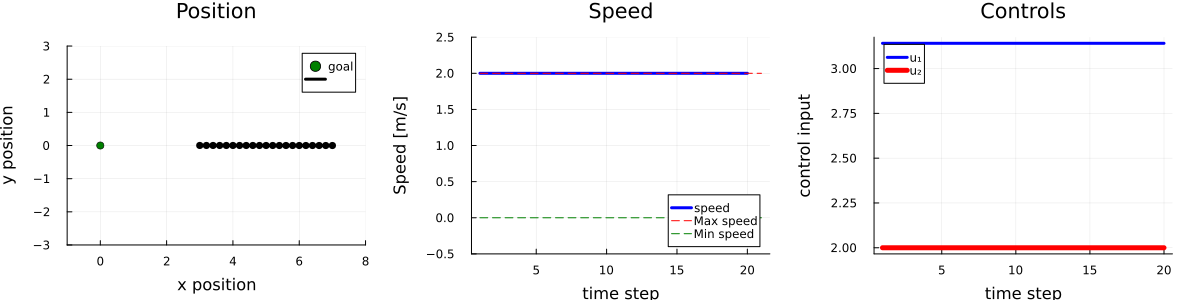

In [3]:
dt = 0.1
velocity_max = 2.0
human = SingleIntegratorPolar2D(dt, velocity_max, [pi, 2.])

time_horizon = 20
Q = zeros(Float64, human.state_dim, human.state_dim)
R = diagm([0.; 0.2]) 
Qt = diagm([10.; 10.])
markup = 1.
collision_slack = 30.
trust_region_weight = 1.
inconvenience_weights = [1.; 1.; 0.05]
collision_radius = 0.25
inconvenience_ratio = 0.1


hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)

opt_params = PlannerOptimizerParams(human, hps, [7.;0.], [0.;0.],"ECOS")
opt_params.goal_state = [0.; 0.]
problem = IdealProblem(human, hps, opt_params)
problem, xs, us = @time solve(problem, iterations=4, verbose=false, keep_history=true);
human_states = xs[end]
plot_solve_solution(problem)

In [4]:
dt = 0.1
velocity_max = 2.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [pi, 3.])
robot = Unicycle(dt, velocity_max, [1.0, 2.])
# robot = DoubleIntegrator2D(dt, velocity_max, [1.0, 1.0])

time_horizon = 20
Q = diagm([0.0; 0.0; 0.])
R = diagm([0.5; 0.1]) 
Qt = diagm([3.; 3.; 0.])
markup = 1.0
collision_slack = 20.
trust_region_weight = 1.
inconvenience_weights = [1.; 1.; 0.]
collision_radius = 0.5
inconvenience_ratio = 100.

hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)

opt_params = PlannerOptimizerParams(robot, hps, [0.;0.], [7.;0.], matrix_to_vector_of_vectors(get_position(human, human_states)), "ECOS")
opt_params.goal_state = [7.; 1.; 0.]
ideal_problem = IdealProblem(robot, hps, opt_params)
ideal_problem, xs, us = @time solve(ideal_problem, iterations=2, verbose=false, keep_history=true);
# plot_solve_solution(ideal_problem)
opt_params.previous_states = matrix_to_vector_of_vectors(xs[end])
opt_params.previous_controls = matrix_to_vector_of_vectors(us[end])
incon_problem = InconvenienceProblem(robot, hps, opt_params);


  0.006115 seconds (47.61 k allocations: 4.022 MiB)


  0.198190 seconds (494.30 k allocations: 35.909 MiB, 90.22% compilation time)


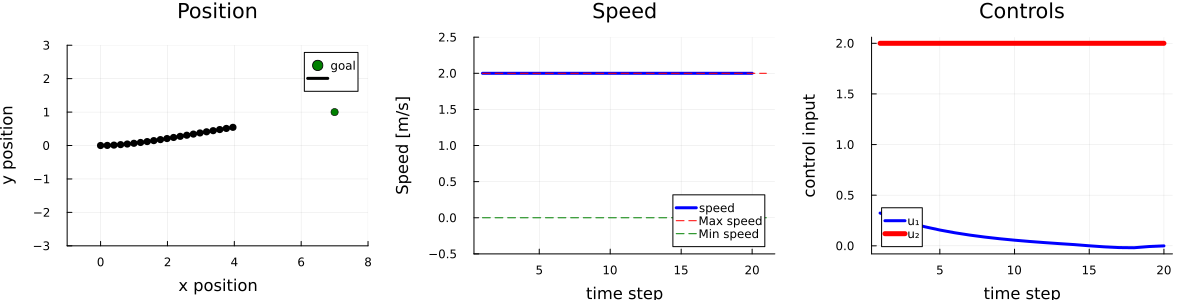

In [5]:
incon_problem, xs, us = @time solve(incon_problem, iterations=5, verbose=false, keep_history=false);
plot_solve_solution(incon_problem)

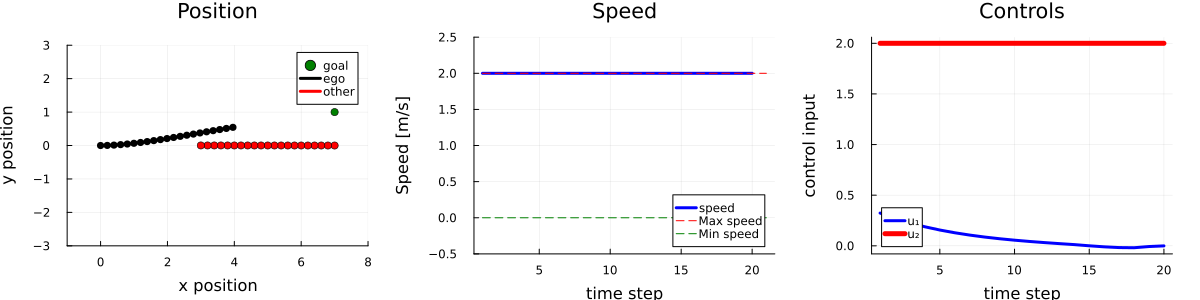

In [6]:
l = @layout [a b c]
width=1200
height=300
alpha0 = 0.2
linewidth = 3
pos_xlims=[-1,8]
pos_ylims=[-3, 3]

xs = value.(incon_problem.model[:x])
us = value.(incon_problem.model[:u])

# plotting position trajectory
goal_state = incon_problem.opt_params.goal_state
plot_traj = scatter(goal_state[1:1], goal_state[2:2], size=(width, height), xlabel="x position", ylabel="y position", title="Position", margin=5mm, color=:green, ylims=pos_ylims, xlims=pos_xlims, aspect_ratio=:equal, label="goal")
plot!(xs[:,1], xs[:,2], color=:black, linewidth=linewidth, label="ego")
scatter!(plot_traj, xs[:,1], xs[:,2], color=:black, label="")

plot!(human_states[:,1], human_states[:,2], color=:red, linewidth=linewidth, label="other")
scatter!(plot_traj, human_states[:,1], human_states[:,2], color=:red, label="")


# plotting speed
dynamics = incon_problem.hps.dynamics
N = incon_problem.hps.time_horizon
speed = get_speed(dynamics, xs, us)
plot_speed = plot(speed, color=:blue, linewidth=linewidth, label="speed", size = (width, height), xlabel="time step", ylabel="Speed [m/s]", title="Speed", margin=5mm, ylim=[dynamics.velocity_min - 0.5, dynamics.velocity_max+0.5], legend=:bottomright)
plot!(plot_speed, 1:N+1, dynamics.velocity_max * ones(Float64, N+1), linestyle=:dash, linewith=linewidth, color=:red, label="Max speed")
plot!(plot_speed, 1:N+1, dynamics.velocity_min * ones(Float64, N+1), linestyle=:dash, linewith=linewidth, color=:green, label="Min speed")


plot_ctrl = plot(us[:,1], color=:blue, linewidth=linewidth, label="u₁", size = (width, height), xlabel="time step", ylabel="control input", title="Controls", margin=5mm)
plot!(plot_ctrl, us[:,2], color=:red, linewidth=linewidth+2, label="u₂")

plot(plot_traj, plot_speed, plot_ctrl, layout = l)